In [1]:
import os, sys
current_dir = os.path.dirname(os.path.abspath("../module.py"))
sys.path.append(current_dir)
from module import *

In [2]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [3]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28, 28, 1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [4]:
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


1/1 [==============================] - 0s 178ms/step
epoch : 0, d_loss : 0.7335, g_loss : 0.4988
1/1 [==============================] - 0s 68ms/step
epoch : 1, d_loss : 0.5038, g_loss : 0.2184
1/1 [==============================] - 0s 35ms/step
epoch : 2, d_loss : 0.4897, g_loss : 0.0880
1/1 [==============================] - 0s 37ms/step
epoch : 3, d_loss : 0.5080, g_loss : 0.0639
1/1 [==============================] - 0s 36ms/step
epoch : 4, d_loss : 0.4913, g_loss : 0.1015
1/1 [==============================] - 0s 37ms/step
epoch : 5, d_loss : 0.4786, g_loss : 0.2097
1/1 [==============================] - 0s 45ms/step
epoch : 6, d_loss : 0.4540, g_loss : 0.3976
1/1 [==============================] - 0s 42ms/step
epoch : 7, d_loss : 0.4595, g_loss : 0.6069
1/1 [==============================] - 0s 40ms/step
epoch : 8, d_loss : 0.4341, g_loss : 0.7969
1/1 [==============================] - 0s 40ms/step
epoch : 9, d_loss : 0.4917, g_loss : 0.8239
1/1 [==============================] - 

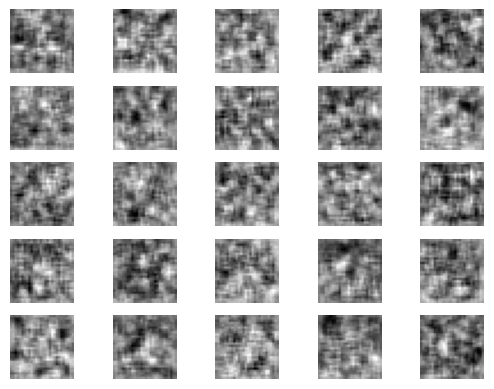

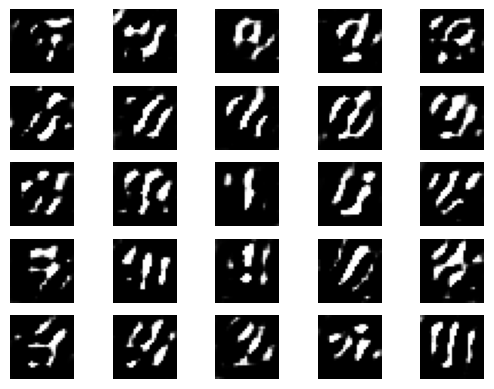

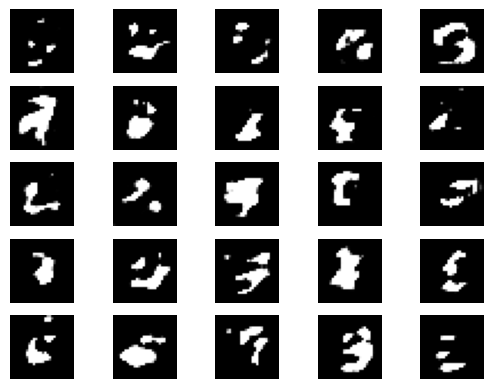

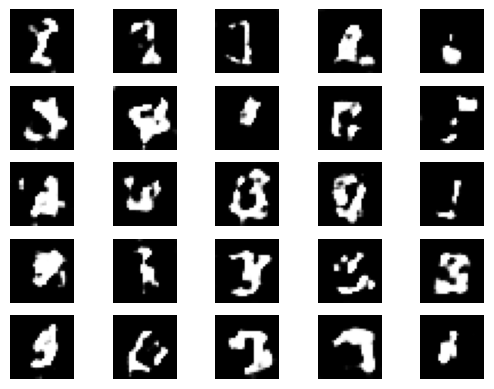

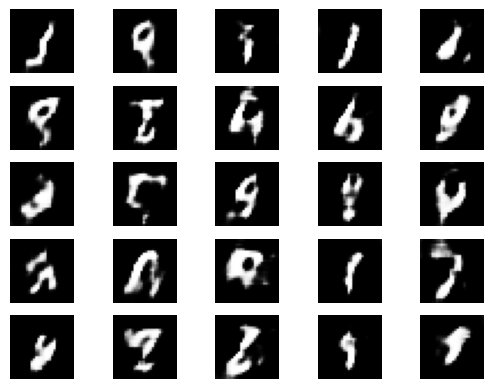

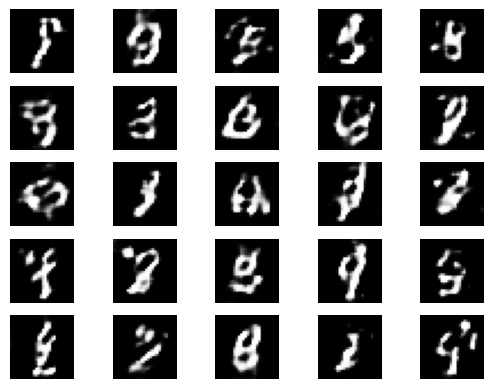

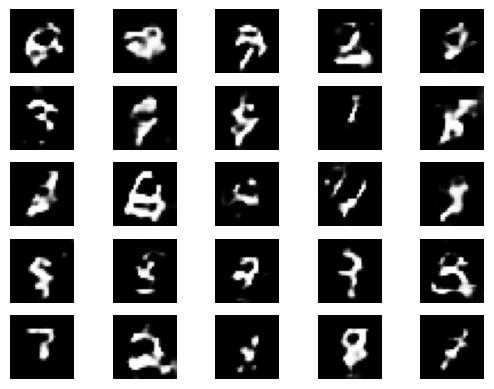

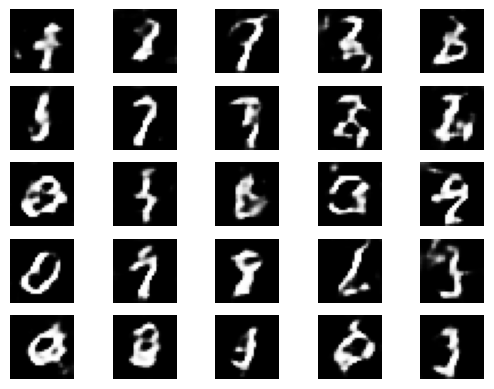

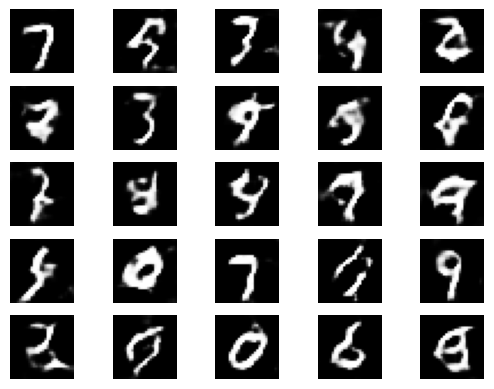

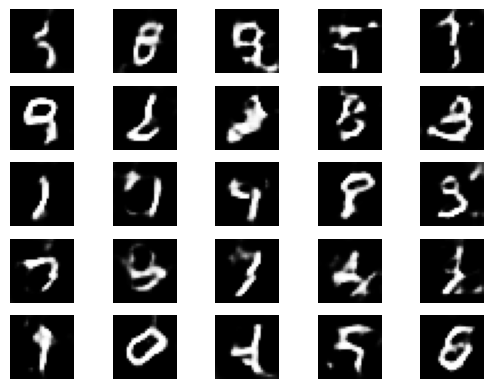

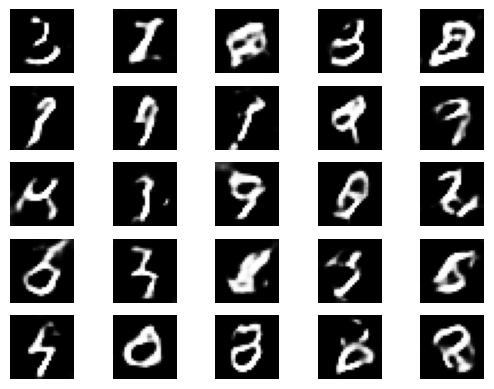

In [5]:
import os

os.makedirs("gan_images", exist_ok=True)

def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

    X_train = (X_train - 127.5) / 127.5

    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        print(f'epoch : {i:d}, d_loss : {d_loss:.4f}, g_loss : {g_loss:.4f}')

        if i % saving_interval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig(f'gan_images/gan_mnist_{i:d}.png')

gan_train(2001, 32, 200)